# Treinamento e Avaliação de Modelos de Classificação de Falhas

Este notebook treina três modelos (XGBoost, QDA e SVM) para classificar falhas em rolamentos com base em atributos extraídos.

**Dados de Entrada**:
*   `data/df_treino_com_atributos.pkl`
*   `data/df_teste_com_atributos.pkl`

In [15]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb

# Configuração de plot
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

## 1. Carregamento dos Dados

In [16]:
# Caminhos relativos
base_dir = 'C:/Users/Cliente/Documents/GitHub/TCC'
data_dir = os.path.join(base_dir, 'data')

path_treino = os.path.join(data_dir, 'df_treino_com_atributos.pkl')
path_teste = os.path.join(data_dir, 'df_teste_com_atributos.pkl')

print(f"Carregando {path_treino}...")
df_treino = pd.read_pickle(path_treino)

print(f"Carregando {path_teste}...")
df_teste = pd.read_pickle(path_teste)

print(f"Treino shape: {df_treino.shape}")
print(f"Teste shape: {df_teste.shape}")

Carregando C:/Users/Cliente/Documents/GitHub/TCC\data\df_treino_com_atributos.pkl...
Carregando C:/Users/Cliente/Documents/GitHub/TCC\data\df_teste_com_atributos.pkl...
Treino shape: (2390, 13)
Teste shape: (5104, 13)


## 2. Pré-processamento e Seleção de Features

In [17]:
# Definição das Features (X) e Target (y)
features = [
    'TF2_std', 'TF3_rms', 'TF4_fator_forma', 
    'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral'
]
target_col = 'tipo_falha_adicionada'

print(f"Features selecionadas ({len(features)}): {features}")

# Filtrando colunas
X_train = df_treino[features].copy()
y_train_raw = df_treino[target_col].copy()

X_test = df_teste[features].copy()
y_test_raw = df_teste[target_col].copy()

# Codificação das classes (Label Encoding)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

class_names = le.classes_
print("Classes identificadas:", class_names)

# Normalização dos dados (Importante para SVM e ajuda em geral)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dataframes normalizados para visualização se necessário
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

Features selecionadas (6): ['TF2_std', 'TF3_rms', 'TF4_fator_forma', 'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral']
Classes identificadas: ['Esfera' 'Normal' 'Pista Externa' 'Pista Interna']


## 3. Treinamento e Avaliação

In [18]:
def plot_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    # Normalized CM for better insight
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusão - {title}')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.show()
    
    print(f"\nRelatório de Classificação: {title}\n")
    print(classification_report(y_true, y_pred, target_names=classes))

### 3.1 XGBoost Classifier

Iniciando otimização de hiperparâmetros do XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\Cliente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [11:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Otimização concluída em 6.70 segundos.
Melhores parâmetros encontrados: {'colsample_bytree': np.float64(0.6739417822102108), 'gamma': np.float64(0.4847923138822793), 'learning_rate': np.float64(0.24253984700833436), 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 319, 'subsample': np.float64(0.8909087983425683)}
Melhor acurácia (CV): 0.6853

Acurácia no Teste (Melhor Modelo): 0.5139


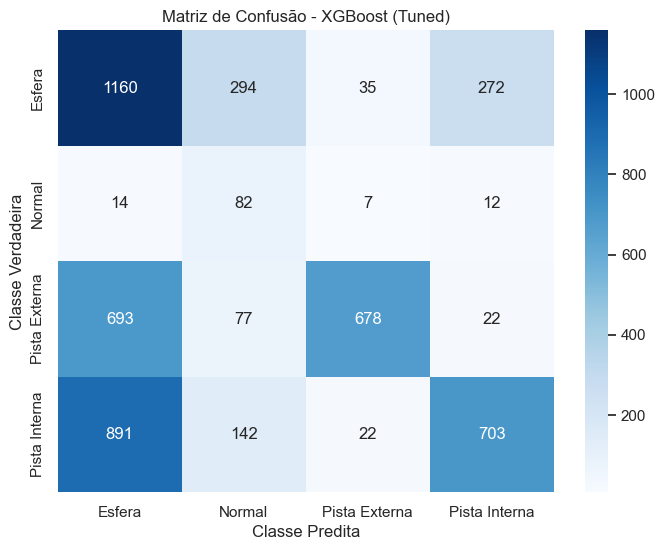


Relatório de Classificação: XGBoost (Tuned)

               precision    recall  f1-score   support

       Esfera       0.42      0.66      0.51      1761
       Normal       0.14      0.71      0.23       115
Pista Externa       0.91      0.46      0.61      1470
Pista Interna       0.70      0.40      0.51      1758

     accuracy                           0.51      5104
    macro avg       0.54      0.56      0.47      5104
 weighted avg       0.65      0.51      0.53      5104



In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
import time

print("Iniciando otimização de hiperparâmetros do XGBoost...")

# 1. Definir o modelo base
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

# 2. Definir o espaço de busca (Hyperparameter Grid)
param_dist = {
    'n_estimators': randint(50, 400),        # Número de árvores
    'learning_rate': uniform(0.01, 0.3),     # Taxa de aprendizado
    'max_depth': randint(3, 10),             # Profundidade máxima da árvore
    'min_child_weight': randint(1, 7),       # Peso mínimo para criar um novo nó
    'gamma': uniform(0, 0.5),                # Redução mínima de perda para dividir
    'subsample': uniform(0.6, 0.4),          # Fração de amostras para treinar cada árvore
    'colsample_bytree': uniform(0.6, 0.4)    # Fração de features para cada árvore
}

# 3. Configurar o RandomizedSearchCV
# n_iter=20 significa que ele vai testar 20 combinações aleatórias.
# Aumente n_iter para uma busca mais exaustiva (mas demora mais).
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,           # Cross-validation de 3 folds
    verbose=1,
    random_state=42,
    n_jobs=-1       # Usar todos os processadores
)

# 4. Executar a busca
start_time = time.time()
random_search.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"Otimização concluída em {end_time - start_time:.2f} segundos.")
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")
print(f"Melhor acurácia (CV): {random_search.best_score_:.4f}")

# 5. Usar o melhor modelo para prever no teste
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nAcurácia no Teste (Melhor Modelo): {acc_xgb:.4f}")

# Plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost (Tuned)", class_names)

### 3.2 Quadratic Discriminant Analysis (QDA)

Treinando QDA...
Acurácia QDA: 0.4293


C:\Users\Cliente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\Cliente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\Cliente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help red

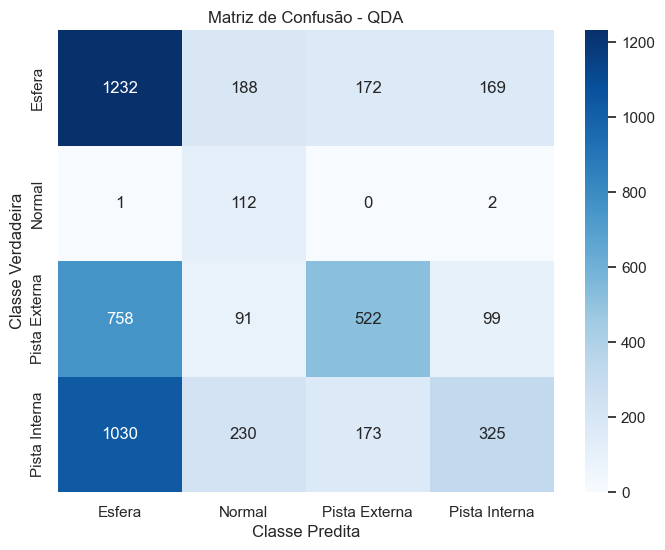


Relatório de Classificação: QDA

               precision    recall  f1-score   support

       Esfera       0.41      0.70      0.52      1761
       Normal       0.18      0.97      0.30       115
Pista Externa       0.60      0.36      0.45      1470
Pista Interna       0.55      0.18      0.28      1758

     accuracy                           0.43      5104
    macro avg       0.43      0.55      0.39      5104
 weighted avg       0.51      0.43      0.41      5104



In [20]:
print("Treinando QDA...")
model_qda = QuadraticDiscriminantAnalysis()

model_qda.fit(X_train_scaled, y_train)
y_pred_qda = model_qda.predict(X_test_scaled)

acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"Acurácia QDA: {acc_qda:.4f}")

plot_confusion_matrix(y_test, y_pred_qda, "QDA", class_names)

### 3.3 Support Vector Machine (SVM)

Treinando SVM (Kernel RBF)...
Acurácia SVM: 0.4007


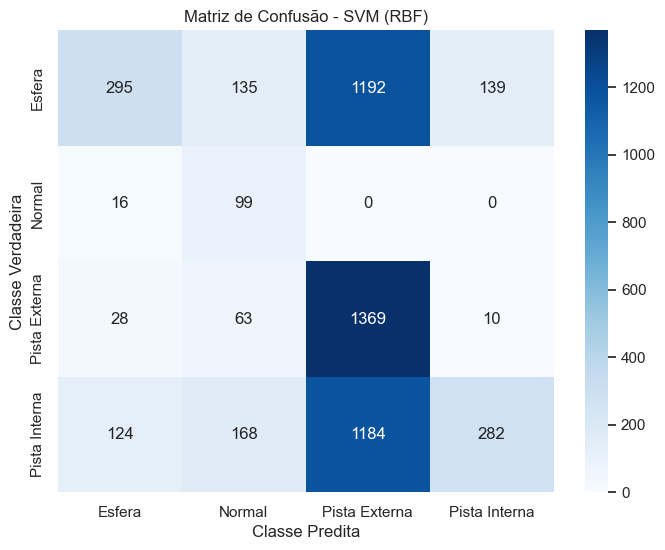


Relatório de Classificação: SVM (RBF)

               precision    recall  f1-score   support

       Esfera       0.64      0.17      0.27      1761
       Normal       0.21      0.86      0.34       115
Pista Externa       0.37      0.93      0.53      1470
Pista Interna       0.65      0.16      0.26      1758

     accuracy                           0.40      5104
    macro avg       0.47      0.53      0.35      5104
 weighted avg       0.56      0.40      0.34      5104



In [21]:
print("Treinando SVM (Kernel RBF)...")
model_svm = SVC(kernel='rbf', C=2.0, random_state=0)

model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Acurácia SVM: {acc_svm:.4f}")

plot_confusion_matrix(y_test, y_pred_svm, "SVM (RBF)", class_names)

## 4. Comparativo Final

,Modelo,Acurácia
0,XGBoost,0.511364
1,QDA,0.429271
2,SVM,0.400666


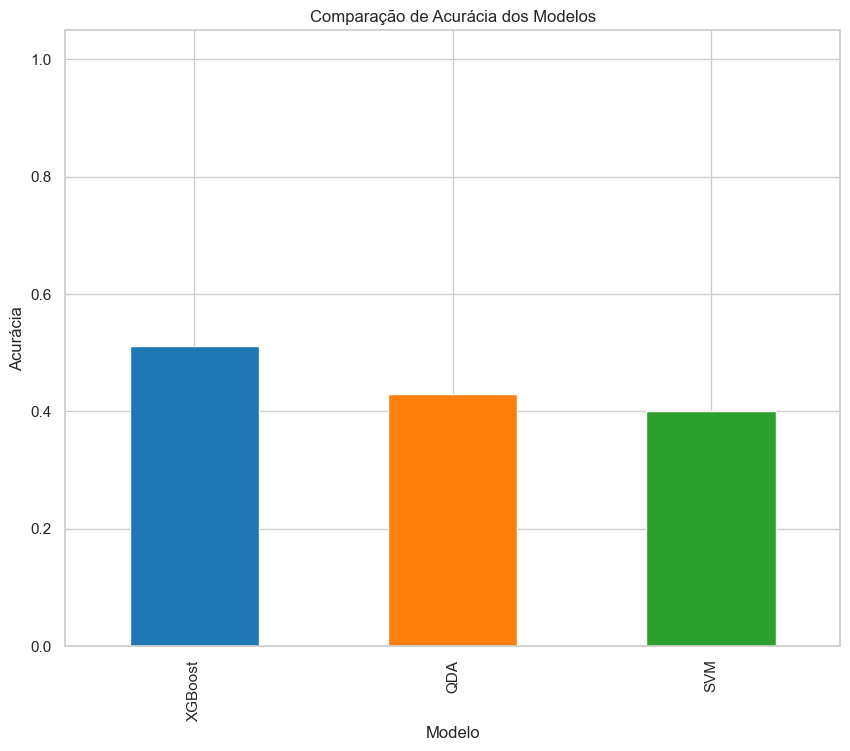

In [22]:
resultados = {
    'Modelo': ['XGBoost', 'QDA', 'SVM'],
    'Acurácia': [acc_xgb, acc_qda, acc_svm]
}

df_res = pd.DataFrame(resultados)
display(df_res)

df_res.plot(x='Modelo', y='Acurácia', kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
plt.title('Comparação de Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.ylim(0, 1.05)
plt.show()